# Quickstart Tutorial

`galtab` is a general approach for calculating the expectation value of
counts-in-cells statistics for a given halo catalog and HOD model. It pretabulates
placeholder galaxies inside each halo to perform rapid, deterministic calculations,
which are ideal to be used inside an MCMC.

This tutorial will demonstrate some basic Counts-in-Cylinders (CiC) calculations
using the intended `galtab` workflow.

## Prerequisites

All of the following are `pip` installable

- `galtab`
    - `numpy`
    - `jax`
    - `astropy`
    - `halotools`
- `matplotlib`
- `jupyterlab`

After installing the above and setting up halotools, you should be able to run the
following cell. In this cell:

- set our cosmology and CiC parameters
- choose an HOD model
- load the simulation data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
from jax import numpy as jnp

from astropy import cosmology
import halotools.empirical_models as htem
import halotools.sim_manager as htsm
import halotools.mock_observables as htmo

import galtab

# Set our CiC parameters (all lengths are in Mpc/h)
proj_search_radius = 2.0
cylinder_half_length = 10.0
cic_edges = np.arange(-0.5, 16)

# Set our cosmology and HOD model
cosmo = cosmology.Planck13
hod = htem.PrebuiltHodModelFactory("zheng07", threshold=-21)

# Load Bolshoi-Planck simulation halos at z=0
halocat = htsm.CachedHaloCatalog(simname="bolplanck", redshift=0)
halocat.halo_table[:5]

halo_vmax_firstacc,halo_dmvir_dt_tdyn,halo_macc,halo_scale_factor,halo_vmax_mpeak,halo_m_pe_behroozi,halo_delta_vmax_behroozi17,halo_xoff,halo_spin,halo_tidal_force,halo_scale_factor_firstacc,halo_c_to_a,halo_mvir_firstacc,halo_scale_factor_last_mm,halo_tidal_id,halo_scale_factor_mpeak,halo_pid,halo_m500c,halo_id,halo_halfmass_scale_factor,halo_upid,halo_t_by_u,halo_rvir,halo_vpeak,halo_dmvir_dt_100myr,halo_mpeak,halo_m_pe_diemer,halo_jx,halo_jy,halo_jz,halo_m2500c,halo_mvir,halo_voff,halo_axisA_z,halo_axisA_x,halo_axisA_y,halo_y,halo_b_to_a,halo_x,halo_z,halo_m200b,halo_vacc,halo_scale_factor_lastacc,halo_vmax,halo_m200c,halo_vx,halo_vy,halo_vz,halo_dmvir_dt_inst,halo_tidal_force_tdyn,halo_rs,halo_nfw_conc,halo_hostid,halo_mvir_host_halo
float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,int64,float32,int64,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32
1001.57,12810.0,200800000000000.0,1.00231,1001.57,202700000000000.0,-0.0026,0.0257357,0.02391,0.11954,1.00231,0.47559,200800000000000.0,0.28343,2812606193,1.002,-1,116580000000000.0,2811042639,0.41506,-1,0.593,1.190447,1091.38,17390.0,200800000000000.0,111800000000000.0,2536000000000000.0,-474400000000000.0,-6566000000000000.0,65777000000000.0,200800000000000.0,21.34,19.2231,59.7891,-18.8001,43.14082,0.63663,36.17984,17.96339,223780000000000.0,1001.57,1.00231,1001.57,158240000000000.0,16.1,8.51,-78.88,17390.0,0.12244,0.137953,8.629367,2811042639,200800000000000.0
895.2,13760.0,179600000000000.0,1.00231,895.2,181000000000000.0,-0.01065,0.041987,0.06297,0.50587,1.00231,0.56181,179600000000000.0,0.29862,2811077105,1.002,-1,100360000000000.0,2811055606,0.50618,-1,0.627,1.146849,969.05,7324.0,179600000000000.0,128700000000000.0,1.074e+16,4931000000000000.0,-1.185e+16,47026000000000.0,179600000000000.0,41.91,41.2062,34.6803,17.8882,49.54417,0.8397,45.36644,40.01593,204460000000000.0,895.2,1.00231,895.2,142290000000000.0,2.46,264.77,-128.08,7324.0,0.491,0.185805,6.172326,2811055606,179600000000000.0
853.83,4666.0,129800000000000.0,1.00231,853.83,149500000000000.0,0.00531,0.026461901,0.03607,0.07568,1.00231,0.66381,129800000000000.0,0.49606,2810630242,1.002,-1,87766000000000.0,2809250167,0.491,-1,0.5774,1.029343,926.37,2747.0,129800000000000.0,80320000000000.0,2133000000000000.0,-3236000000000000.0,-3111000000000000.0,39496000000000.0,129800000000000.0,23.35,-17.5268,38.9596,24.3626,13.88261,0.76149,22.02318,9.80153,141210000000000.0,853.83,1.00231,853.83,112010000000000.0,18.49,124.89,-35.19,2747.0,0.10074,0.119293995,8.628624,2809250167,129800000000000.0
777.64,4401.0,103000000000000.0,1.00231,777.64,104800000000000.0,0.00498,0.0516998,0.05031,0.09677,1.00231,0.47302,103000000000000.0,0.38469,2820592816,1.002,-1,57781000000000.0,2809483946,0.65806,-1,0.6152,0.952978,831.17,2747.0,103000000000000.0,64200000000000.0,1713000000000000.0,-1488000000000000.0,4582000000000000.0,30529000000000.0,103000000000000.0,98.45,24.7744,-10.3568,38.9949,36.67881,0.7881,12.29788,34.18085,115110000000000.0,777.64,1.00231,777.64,82069000000000.0,-281.37,-115.39,-391.28,2747.0,0.10259,0.132334,7.201309,2809483946,103000000000000.0
748.56,11480.0,99470000000000.0,1.00231,748.56,107600000000000.0,0.05989,0.0779697,0.0348,0.12465,1.00231,0.47409,99470000000000.0,0.63275,2809483946,1.002,-1,59100000000000.0,2809272603,0.63781,-1,0.67,0.941893,748.56,5218.0,99470000000000.0,70970000000000.0,1207000000000000.0,-2126000000000000.0,-2677000000000000.0,26267000000000.0,99470000000000.0,118.79,29.2183,52.7796,6.18836,26.12877,0.66155,10.66037,22.5009,108110000000000.0,748.56,1.00231,748.56,84337000000000.0,-43.87,292.95,-171.47,5218.0,0.1579,0.14077,6.691006,2809272603,99470000000000.0


## Calculate CiC the standard way with `halotools`

- Populate the halocat with galaxies probabilistically from the HOD model
- Compute the number of neighbors within a cylinder around each neighbor
- Tally up a histogram of the neighbor counts for a given set of CiC bins

In [2]:
# Choose your HOD parameters (in this case, we will keep them the same)
hod.param_dict.update({})

# Populated model galaxies and get their Cartesian coordinates
hod.populate_mock(halocat)
galaxies = hod.mock.galaxy_table
xyz = htmo.return_xyz_formatted_array(
    galaxies["x"], galaxies["y"], galaxies["z"], velocity=galaxies["vz"],
    velocity_distortion_dimension="z", period=halocat.Lbox, cosmology=cosmo
)

# Compute CiC (self-counting subtracted by the `-1`)
cic_counts = htmo.counts_in_cylinders(
    xyz, xyz, proj_search_radius, cylinder_half_length) - 1
cic_halotools = np.histogram(cic_counts, bins=cic_edges, density=True)[0]
cic_halotools

array([0.36245417, 0.2486824 , 0.1560495 , 0.08942484, 0.05293309,
       0.03305454, 0.01976398, 0.0126604 , 0.00796288, 0.00498396,
       0.00504125, 0.00223419, 0.00200504, 0.00114574, 0.00091659,
       0.00068744])

## Now let's do it the `galtab` way

In [3]:
# Give the Tabulator the halo catalog and a fiducial HOD model
gtab = galtab.GalaxyTabulator(halocat, hod)

# Prepare the CICTabulator to make predictions
cictab = galtab.CICTabulator(gtab, proj_search_radius, cylinder_half_length,
                            bin_edges=cic_edges)

# Choose your HOD parameters (in this case, we will keep them the same)
hod.param_dict.update({})

# Predict CiC for this model
cic_galtab = cictab.predict(hod)
cic_galtab

DeviceArray([0.35813972, 0.25630063, 0.15486425, 0.0911006 , 0.05365718,
             0.03209952, 0.0194987 , 0.01234983, 0.0078652 , 0.00524053,
             0.00336971, 0.00212132, 0.00131376, 0.00090561, 0.00068343,
             0.00049   ], dtype=float32)

## Plot the `galtab` vs. `halotools` comparison

- `galtab` predicts the CiC expectation value (smooth + differentiable)
- `halotools` predicts a CiC realization (noisy)

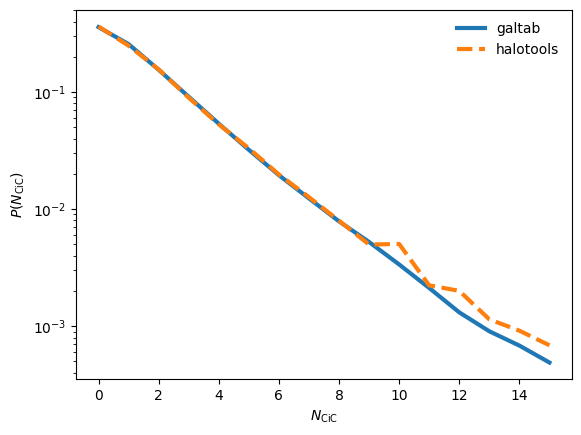

In [4]:
cic_cens = 0.5 * (cic_edges[:-1] + cic_edges[1:])
plt.semilogy(cic_cens, cic_galtab, label="galtab", lw=3)
plt.semilogy(cic_cens, cic_halotools, label="halotools", lw=3, ls="--")
plt.legend(frameon=False)
plt.xlabel("$N_{\\rm CiC}$")
plt.ylabel("$P(N_{\\rm CiC})$")
plt.show()

## **In Development:** Differentiate CiC w.r.t. the HOD parameter $\log M_{\rm min}$

`galtab` is implemented in JAX, so it is in principle portable to GPU and
differentiable, assuming your HOD model is compatible with JAX. Unfortunately,
this requires a few modifications to `halotools` models. In the following cell,
I will show an example of such a modification, taken from the `JaxZheng07Cens` and
`JaxZheng07Sats` implementations in the
[JaxTabCorr](https://github.com/AlanPearl/JaxTabCorr) project.

In [5]:
class JaxZheng07Cens(htem.Zheng07Cens):
    def mean_occupation(self, **kwargs):
        # Retrieve the array storing the mass-like variable
        if 'table' in list(kwargs.keys()):
            mass = kwargs['table'][self.prim_haloprop_key]
        elif 'prim_haloprop' in list(kwargs.keys()):
            mass = jnp.atleast_1d(kwargs['prim_haloprop'])
        else:
            msg = ("\nYou must pass either a ``table`` or ``prim_haloprop`` argument \n"
                   "to the ``mean_occupation`` function of the ``Zheng07Cens`` class.\n")
            raise htem.HalotoolsError(msg)

        return zheng07_cenocc(mass, self.param_dict["logMmin"],
                              self.param_dict["sigma_logM"])


class JaxZheng07Sats(htem.Zheng07Sats):
    def mean_occupation(self, **kwargs):
        if self.modulate_with_cenocc:
            for key, value in list(self.param_dict.items()):
                if key in self.central_occupation_model.param_dict:
                    self.central_occupation_model.param_dict[key] = value

        # Retrieve the array storing the mass-like variable
        if 'table' in list(kwargs.keys()):
            mass = kwargs['table'][self.prim_haloprop_key]
        elif 'prim_haloprop' in list(kwargs.keys()):
            mass = jnp.atleast_1d(kwargs['prim_haloprop'])
        else:
            msg = ("\nYou must pass either a ``table`` or ``prim_haloprop`` argument \n"
                   "to the ``mean_occupation`` function of the ``Zheng07Sats`` class.\n")
            raise htem.HalotoolsError(msg)

        mean_nsat = zheng07_satocc(mass, self.param_dict["logM0"],
                                   self.param_dict["logM1"], self.param_dict["alpha"])

        # If a central occupation model was passed to the constructor,
        # multiply mean_nsat by an overall factor of mean_ncen
        if self.modulate_with_cenocc:
            # compatible with AB models
            mean_ncen = getattr(self.central_occupation_model, "baseline_mean_occupation",
                                self.central_occupation_model.mean_occupation)(**kwargs)
            mean_nsat *= mean_ncen

        return mean_nsat


def vectorized_cond(pred, true_fun, false_fun, operand, safe_operand_value=0):
    # Taken from https://github.com/google/jax/issues/1052
    # ====================================================
    # true_fun and false_fun must act elementwise (i.e. be vectorized)
    true_op = jnp.where(pred, operand, safe_operand_value)
    false_op = jnp.where(pred, safe_operand_value, operand)
    return jnp.where(pred, true_fun(true_op), false_fun(false_op))


@jax.jit
def zheng07_cenocc(mass, logmmin, sigma_logm):
    logm = jnp.log10(mass)
    return 0.5 * (1.0 + jax.scipy.special.erf((logm - logmmin) / sigma_logm))


@jax.jit
def zheng07_satocc(mass, logm0, logm1, alpha):
    m0 = 10. ** logm0
    m1 = 10. ** logm1
    is_nonzero = mass > m0

    def nonzero_func(x):
        return ((x - m0) / m1) ** alpha

    def zero_func(x):
        return 0

    mean_nsat = vectorized_cond(is_nonzero, nonzero_func, zero_func, mass,
                                safe_operand_value=m0 + m1)
    return mean_nsat

Now we can construct a differentiable HOD model with our JAX-compatible mean
occupation functions, which we call `hod_jax`. This model allows us to
differentiate `cictab.predict` with `jax.grad`.

*Note:* You shouldn't try using `jax.jit` directly on `cictab.predict`, since it
contains some I/O lines that can't be compiled. Rest assured that the primary
calculation has already been jitted, and automatically runs on the GPU if available.

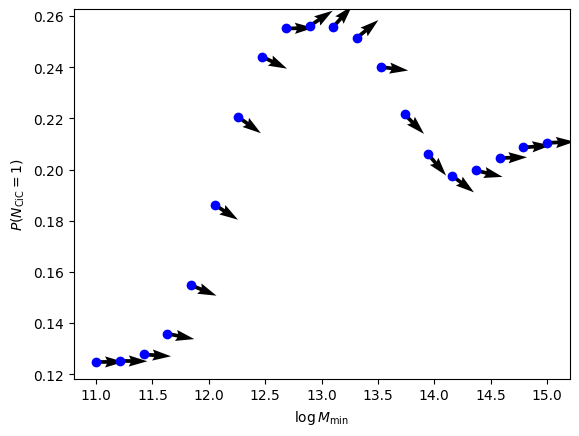

In [6]:
hod_jax = htem.HodModelFactory(
    centrals_occupation=JaxZheng07Cens(threshold=-21),
    satellites_occupation=JaxZheng07Sats(threshold=-21),
    centrals_profile=htem.TrivialPhaseSpace(),
    satellites_profile=htem.NFWPhaseSpace()
)

def calc_cic1(logMmin=12.79):
    hod_jax.param_dict.update({"logMmin": logMmin})
    return cictab.predict(hod_jax, warn_p_over_1=False)[1]

diff_cic1 = jax.grad(calc_cic1)

# Note that we shouldn't make logMmin too much lower than that of our fiducial
# model. If desired, make more conservative choices for the fiducial parameters.
# i.e., low logMmin / logM1 / logM0 values and large sigma_logM values
for logmmin in np.linspace(11.0, 15.0, 20):
    value = calc_cic1(logmmin)
    derivative = diff_cic1(logmmin)

    plt.plot(logmmin, value, "bo")
    plt.quiver(logmmin, value, 1, derivative, angles="xy")

plt.xlabel("$\\log M_{\\rm min}$")
plt.ylabel("$P(N_{\\rm CiC} = 1)$")
plt.show()

## The derivative isn't working *yet*...

- I actually wasn't expecting the above to work, because it's using the Monte-Carlo mode
- But analytic mode moment derivatives aren't working either...
- TODO: Figure out what's going wrong